# Generación de piezas musicales polifónicas con Autoencoder-CNN

In [1]:
!pip install pypianoroll

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 72.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 7.2 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=71e3cbe080112fe59476b0dbb99889c54f7933b6acca90495f21d5ead5d574ae
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty-midi


In [2]:
import os
import numpy as np
import pandas as pd
import random
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import pypianoroll as pr
import matplotlib.pyplot as plt
import pickle

In [1]:
ENV = 'colab'
if(ENV == 'colab'):
    BASE_PATH = '/content/drive/MyDrive/uni/TFG2023/generative-music/'
    from google.colab import drive
    drive.mount('/content/drive')

elif(ENV == 'local'):
    BASE_PATH = './'
else:
    raise Exception()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DATASET = 'lpd_5'
DATA_PATH=os.path.join(BASE_PATH, 'data')
DATASET_PATH = os.path.join(DATA_PATH, DATASET)

STORE_PATH=os.path.join(BASE_PATH,'generated')

RANDOM_SEED=616
SEQ_LEN=32
RESOLUTION=2

random.seed(RANDOM_SEED)

CONDITIONAL_INSTRUMENTS = {'lpd_5': ['Drums','Guitar','Bass','Strings'],
              'POP909': ['BRIDGE', 'PIANO']}
MAIN_INSTRUMENT = {'lpd_5': 'Piano',
              'POP909': 'MELODY'}

### Clases para el preprocesamiento de los datos y la compilación del modelo

In [4]:
# MAEDatasetEncoder
class MAEDatasetEncoder:

    def __init__(self, path, seq_len=32, delimiter='/', blend_tracks=False, with_csv=False, k=1000):
        self.path = path
        self.seq_len = seq_len
        self.delimiter = delimiter
        self.blend_tracks = blend_tracks
        self.with_csv = with_csv
        self.k = k
        self.parsed_files = self.load()

    def load(self):

        # Get song data from data_path and parse it as a pypianoroll object
        songs = {}

        if(self.with_csv):

            # reading from csv
            files_df = pd.read_csv(os.path.join(self.path,self.with_csv))
            files = files_df['npz_local'].values.tolist()
            sample = random.sample(files, k=self.k)
            print(len(list(set(sample))))

            for file in sample:
                if (file[-3:] == 'mid'):
                    try:
                        song = pr.read(os.path.join(self.path,file))
                        songs[file[:-4]] = song
                    except:
                        print(f'Parsing file {file} failed. Skipping.')
                        continue
                elif (file[-3:] == 'npz'):

                    try:
                        song = pr.load(os.path.join(self.path,file))
                        if(file[:-4] in songs.keys()):
                            print(file[:-4])
                        songs[file[:-4]] = song
                    except:
                        print(f'Parsing file {file} failed. Skipping.')
                        continue
        else:
            # reading from folder
            for path,subdir,files in os.walk(self.path):
                for file in files:
                    if (file[-3:] == 'mid'):
                        try:
                            song = pr.read(os.path.join(path,file))
                            songs[file[:-4]] = song
                        except:
                            print(f'Parsing file {file} failed. Skipping.')
                            continue

        print(f'Loaded {len(songs.keys())} songs.')
        return songs

    def encode(self):
        encoded_files = {}
        titles, files = list(self.parsed_files.keys()), list(self.parsed_files.values())


        for i,file in enumerate(files):

            # Clean short songs
            if(file.get_max_length() < self.seq_len):
                print(f'Skipping song {titles[i]}')
                continue

            encoded_file = self.encode_song(file)
            encoded_files[titles[i]] = encoded_file

        print(f'Loaded {len(encoded_files.keys())} songs.')
        self.encoded_files = encoded_files

    def encode_song(self, song):

        processed_tracks = {}

        padded = song.set_resolution(RESOLUTION).pad_to_same()

        if(self.blend_tracks):
            return { 'MAIN_TRACK':padded.binarize().blend().astype(float) }

        for t in song.tracks:
            bt = t.binarize()
            processed_tracks[bt.name] = bt.pianoroll.astype(float)
        return processed_tracks

In [5]:
class MAESequenceGenerator:
    def __init__(self, encoder, seq_len=SEQ_LEN):
        self.encoded_files = encoder.encoded_files
        self.seq_len = seq_len

    def generate_sequences_main(self, validation_split=0.15):
        inputs = []
        outputs = []

        for n, s in self.encoded_files.items():
            pianoroll = s[MAIN_INSTRUMENT[DATASET]]

            X_s = [pianoroll[SEQ_LEN*i:SEQ_LEN*i + SEQ_LEN] for i in range(int((pianoroll.shape[0] - SEQ_LEN)/SEQ_LEN))]
            y_s = [pianoroll[SEQ_LEN*i + SEQ_LEN:SEQ_LEN*i + SEQ_LEN*2] for i in range(int((pianoroll.shape[0] - SEQ_LEN)/SEQ_LEN))]

            inputs = inputs + X_s
            outputs = outputs + y_s

        X = np.reshape(inputs, (len(inputs), self.seq_len, 128))
        y = np.reshape(outputs, (len(outputs), self.seq_len, 128))

        print(f'Input shape: {X.shape}')
        print(f'Output shape: {y.shape}')

        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=validation_split, random_state=RANDOM_SEED)

        return X_train, X_valid, y_train, y_valid

    def generate_sequences_conditional(self, instrument, validation_split=0.15):
        cond_inputs = {}
        cond_outputs = {}

        main_inputs = []
        inputs = []
        outputs = []
        for n, s in self.encoded_files.items():
            main_pianoroll = s[MAIN_INSTRUMENT[DATASET]]
            main_sequences = [main_pianoroll[SEQ_LEN*i + SEQ_LEN:SEQ_LEN*i + SEQ_LEN*2] for i in range(int((main_pianoroll.shape[0] - SEQ_LEN)/SEQ_LEN))]

            pianoroll = s[instrument]

            X_s = [pianoroll[SEQ_LEN*i:SEQ_LEN*i + SEQ_LEN] for i in range(int((pianoroll.shape[0] - SEQ_LEN)/SEQ_LEN))]

            y_s = [pianoroll[SEQ_LEN*i + SEQ_LEN:SEQ_LEN*i + SEQ_LEN*2] for i in range(int((pianoroll.shape[0] - SEQ_LEN)/SEQ_LEN))]

            main_inputs = main_inputs + main_sequences
            inputs = inputs + X_s
            outputs = outputs + y_s

        X_main = np.reshape(main_inputs, (len(main_inputs), self.seq_len, 128))
        X_cond = np.reshape(inputs, (len(inputs), self.seq_len, 128))
        y = np.reshape(outputs, (len(outputs), self.seq_len, 128))

        print(f'Main instrument input shape: {X_main.shape}')
        print(f'{instrument} input shape: {X_cond.shape}')
        print(f'Output shape: {y.shape}')

        X_cond_train, X_cond_valid, X_main_train, X_main_valid, y_train, y_valid = train_test_split(X_cond, X_main, y, test_size=validation_split, random_state=RANDOM_SEED)

        return ([X_cond_train, X_main_train],[X_cond_valid, X_main_valid],y_train,y_valid)


In [6]:
class MAEMain:
    def __init__(self, instrument, enc_num_units, enc_kernels, enc_strides, dec_num_units, dec_kernels, dec_strides, seq_len, lr, latent_dim = 64, from_hdf5=False):

        self.name = f'{DATASET}_{instrument}_autoencoder'

        if(not os.path.exists(os.path.join(BASE_PATH, 'weights',self.name))):
            os.mkdir(os.path.join(BASE_PATH, 'weights',self.name))

        self.weights_folder = os.path.join(BASE_PATH, 'weights',self.name)

        input_shape = (seq_len, 128, 1)

        if(from_hdf5):
            model_path = os.path.join(self.weights_folder, from_hdf5)
            self.autoencoder = keras.models.load_model(model_path)

        # ENCODER
        i_e = keras.layers.Input(shape=input_shape, name='enc_input')

        x = keras.layers.Conv2D(filters=enc_num_units[0], kernel_size=enc_kernels[0], strides=enc_strides[0], padding='same', name='conv_1')(i_e)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)

        x = keras.layers.Dropout(0.4)(x)

        x = keras.layers.Conv2D(filters=enc_num_units[1], kernel_size=enc_kernels[1], strides=enc_strides[1], padding='same', name='conv_2')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)

        x = keras.layers.Dropout(0.4)(x)

        x = keras.layers.Conv2D(filters=enc_num_units[2], kernel_size=enc_kernels[2], strides=enc_strides[2], padding='same', name='conv_3')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)

        dec_shape = K.int_shape(x)[1:]

        x = keras.layers.Flatten()(x)

        e = keras.layers.Dense(latent_dim, name='latent')(x)

        self.encoder = keras.Model(i_e, e, name='cnn_encoder')


        # DECODER
        i_d = keras.layers.Input(shape=(latent_dim,), name='dec_input')

        x = keras.layers.Dense(np.prod(dec_shape))(i_d)
        x = keras.layers.Reshape((dec_shape))(x)

        x = keras.layers.Conv2DTranspose(filters=dec_num_units[0], kernel_size=dec_kernels[0], strides=dec_strides[0], padding='same', name='deconv_1')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)

        x = keras.layers.Conv2DTranspose(filters=dec_num_units[1], kernel_size=dec_kernels[1], strides=dec_strides[1], padding='same', name='deconv_2')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)

        x = keras.layers.Conv2DTranspose(filters=dec_num_units[2], kernel_size=dec_kernels[2], strides=dec_strides[2], padding='same', name='deconv_3')(x)
        d = keras.layers.Activation('sigmoid')(x)

        self.decoder = keras.Model(i_d, d, name='cnn_decoder')

        autoencoder_input = i_e
        autoencoder_output = self.decoder(e)

        self.autoencoder = keras.Model(autoencoder_input, autoencoder_output, name='cnn_autoencoder')

        # COMPILATION
        opt = keras.optimizers.Adam(learning_rate=lr)

        self.autoencoder.compile(optimizer=opt, loss='mean_squared_error')

        self.get_model_summary()


    def fit_model(self, train_inputs, train_outputs, validation_inputs, validation_outputs, store_path, epochs=1000, batch_size=32):

        weights_folder = self.weights_folder

        checkpoint = ModelCheckpoint(
            os.path.join(weights_folder, f"{self.name}_weights.h5"),
            monitor='loss',
            verbose=0,
            save_best_only=True,
            mode='min'
        )

        early_stopping = EarlyStopping(
            monitor='loss'
            , restore_best_weights=True
            , patience = 10
        )


        callbacks_list = [ checkpoint, early_stopping ]

        history = self.autoencoder.fit(train_inputs, train_outputs
                  , epochs=epochs, batch_size=batch_size
                  , callbacks=callbacks_list
                  , validation_data=(validation_inputs, validation_outputs)
                  , shuffle=True
                 )

        self.autoencoder.save(os.path.join(weights_folder, f"{self.name}.h5"))

        return history

    def get_model_summary(self):
        self.encoder.summary()
        print('--------------------')
        self.decoder.summary()
        print('--------------------')
        self.autoencoder.summary()

    def plot_model_graph(self, component='full'):
        if(component == 'encoder'):
            return plot_model(self.encoder)
        elif(component == 'decoder'):
            return plot_model(self.decoder)
        elif(component == 'full'):
            return plot_model(self.autoencoder)
        else:
            raise Exception("No valid component specified (Only 'full', 'encoder' or 'decoder' are valid)")

    def plot_loss(self, history):
        plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])

        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train loss', 'Validation loss'])
        plt.show()

In [7]:
class MAEConditional:
    def __init__(self, instrument, enc_num_units, enc_kernels, enc_strides, dec_num_units, dec_kernels, dec_strides, seq_len, lr, latent_dim = 64, from_hdf5=False):

        self.name = f'{DATASET}_{instrument}_cond_autoencoder'

        if(not os.path.exists(os.path.join(BASE_PATH, 'weights',self.name))):
            os.mkdir(os.path.join(BASE_PATH, 'weights',self.name))

        self.weights_folder = os.path.join(BASE_PATH, 'weights',self.name)

        if(from_hdf5):
            model_path = os.path.join(self.weights_folder, from_hdf5)
            self.autoencoder = keras.models.load_model(model_path)

        input_shape = (seq_len, 128, 1)

        # PREVIOUS HARMONY ENCODER
        i_e_prev = keras.layers.Input(shape=input_shape, name='enc_input_prev')

        x_prev = keras.layers.Conv2D(filters=enc_num_units[0], kernel_size=enc_kernels[0], strides=enc_strides[0], padding='same', name='conv_1_prev')(i_e_prev)
        x_prev = keras.layers.BatchNormalization()(x_prev)
        x_prev = keras.layers.LeakyReLU()(x_prev)

        x_prev = keras.layers.Dropout(0.4)(x_prev)

        x_prev = keras.layers.Conv2D(filters=enc_num_units[1], kernel_size=enc_kernels[1], strides=enc_strides[1], padding='same', name='conv_2_prev')(x_prev)
        x_prev = keras.layers.BatchNormalization()(x_prev)
        x_prev = keras.layers.LeakyReLU()(x_prev)

        x_prev = keras.layers.Dropout(0.4)(x_prev)

        x_prev = keras.layers.Conv2D(filters=enc_num_units[2], kernel_size=enc_kernels[2], strides=enc_strides[2], padding='same', name='conv_3_prev')(x_prev)
        x_prev = keras.layers.BatchNormalization()(x_prev)
        x_prev = keras.layers.LeakyReLU()(x_prev)

        dec_shape = K.int_shape(x_prev)[1:]

        x_prev = keras.layers.Flatten()(x_prev)

        # MAIN MELODY ENCODER
        i_e_main = keras.layers.Input(shape=input_shape, name='enc_input_main')

        x_main = keras.layers.Conv2D(filters=enc_num_units[0], kernel_size=enc_kernels[0], strides=enc_strides[0], padding='same', name='conv_1_main')(i_e_main)
        x_main = keras.layers.BatchNormalization()(x_main)
        x_main = keras.layers.LeakyReLU()(x_main)

        x_main = keras.layers.Dropout(0.4)(x_main)

        x_main = keras.layers.Conv2D(filters=enc_num_units[1], kernel_size=enc_kernels[1], strides=enc_strides[1], padding='same', name='conv_2_main')(x_main)
        x_main = keras.layers.BatchNormalization()(x_main)
        x_main = keras.layers.LeakyReLU()(x_main)

        x_main = keras.layers.Dropout(0.4)(x_main)

        x_main = keras.layers.Conv2D(filters=enc_num_units[2], kernel_size=enc_kernels[2], strides=enc_strides[2], padding='same', name='conv_3_main')(x_main)
        x_main = keras.layers.BatchNormalization()(x_main)
        x_main = keras.layers.LeakyReLU()(x_main)

        x_main = keras.layers.Flatten()(x_main)

        # CONCAT PREV & MAIN
        x = keras.layers.Concatenate()([x_prev,x_main])

        e = keras.layers.Dense(latent_dim, name='latent')(x)

        self.encoder = keras.Model([i_e_prev, i_e_main], e, name='cnn_encoder')


        # DECODER
        i_d = keras.layers.Input(shape=(latent_dim,), name='dec_input')

        x = keras.layers.Dense(np.prod(dec_shape))(i_d)
        x = keras.layers.Reshape((dec_shape))(x)

        x = keras.layers.Conv2DTranspose(filters=dec_num_units[0], kernel_size=dec_kernels[0], strides=dec_strides[0], padding='same', name='deconv_1')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)

        x = keras.layers.Conv2DTranspose(filters=dec_num_units[1], kernel_size=dec_kernels[1], strides=dec_strides[1], padding='same', name='deconv_2')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)

        x = keras.layers.Conv2DTranspose(filters=dec_num_units[2], kernel_size=dec_kernels[2], strides=dec_strides[2], padding='same', name='deconv_3')(x)
        d = keras.layers.Activation('sigmoid')(x)

        self.decoder = keras.Model(i_d, d, name='cnn_decoder')

        autoencoder_input = [i_e_prev, i_e_main]
        autoencoder_output = self.decoder(e)

        self.autoencoder = keras.Model(autoencoder_input, autoencoder_output, name='cnn_autoencoder')

        # COMPILATION
        opt = keras.optimizers.Adam(learning_rate=lr)

        self.autoencoder.compile(optimizer=opt, loss='mean_squared_error')

        self.get_model_summary()


    def fit_model(self, train_inputs, train_outputs, validation_inputs, validation_outputs, store_path, epochs=1000, batch_size=32):

        weights_folder = self.weights_folder

        checkpoint = ModelCheckpoint(
            os.path.join(weights_folder, f"{self.name}_weights.h5"),
            monitor='loss',
            verbose=0,
            save_best_only=True,
            mode='min'
        )

        early_stopping = EarlyStopping(
            monitor='loss'
            , restore_best_weights=True
            , patience = 10
        )


        callbacks_list = [ checkpoint, early_stopping ]

        history = self.autoencoder.fit(train_inputs, train_outputs
                  , epochs=epochs, batch_size=batch_size
                  , callbacks=callbacks_list
                  , validation_data=(validation_inputs, validation_outputs)
                  , shuffle=True
                 )

        self.autoencoder.save(os.path.join(weights_folder, f"{self.name}.h5"))

        return history

    def get_model_summary(self):
        self.encoder.summary()
        print('--------------------')
        self.decoder.summary()
        print('--------------------')
        self.autoencoder.summary()

    def plot_model_graph(self, component='full'):
        if(component == 'encoder'):
            return plot_model(self.encoder)
        elif(component == 'decoder'):
            return plot_model(self.decoder)
        elif(component == 'full'):
            return plot_model(self.autoencoder)
        else:
            raise Exception("No valid component specified (Only 'full', 'encoder' or 'decoder' are valid)")

    def plot_loss(self, history):
        plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])

        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train loss', 'Validation loss'])
        plt.show()

In [8]:
class MAESampleGenerator:
    def __init__(self, models, encoder, store_path=STORE_PATH):
        self.models = {inst: m.autoencoder for inst,m in models.items()}
        self.encoder = encoder
        self.n_sample = 0
        self.store_path = store_path

    def generate(self, seed, thresholds, sample_length):

        stream = seed.copy()
        prob_heatmaps = seed.copy()
        main_inst = MAIN_INSTRUMENT[DATASET]

        model = self.models[main_inst]
        main_stream = stream[main_inst].astype(float)

        for _ in range(sample_length):
            # main_pianoroll(t) -> main_pianoroll(t+1)
            # inst_pianoroll(t) + main_pianoroll(t+1) -> inst_pianoroll(t+1)
            # generar primero el pasaje siguiente para el instrumento principal
            # despues, para cada instrumento complementario, generar el pasaje siguiente con el pasaje
            # generado para el instrumento principal

            # MAIN INSTRUMENT

            cur_seed = main_stream[-self.encoder.seq_len:]
            threshold = thresholds[main_inst]

            # add dimension for batch
            # (1, max_seq_len, vocab_size)
            p_in = np.reshape(cur_seed, (1,self.encoder.seq_len, 128))

            uniq,counts = np.unique(p_in,return_counts=True)
            print(np.asarray((uniq, counts)).T)

            # make a prediction
            p_out = model.predict(p_in,verbose=0)
            prob_heatmaps[main_inst] = np.append(prob_heatmaps[main_inst],np.reshape(p_out, (self.encoder.seq_len,128)),axis=0)

            p_out[p_out < threshold] = 0.0
            p_out[p_out >= threshold] = 1.0

            # update seed
            p_out = np.reshape(p_out, (self.encoder.seq_len,128))
            print(f'Generated sample from ts={main_stream.shape[0]} to ts={main_stream.shape[0]+self.encoder.seq_len}.')

            # generar instrumentos
            for inst in CONDITIONAL_INSTRUMENTS[DATASET]:
                inst_out, inst_heatmap = self.generate_next(inst, stream[inst][-self.encoder.seq_len:], p_out, thresholds[inst])
                stream[inst] = np.concatenate((stream[inst], inst_out))
                prob_heatmaps[inst] = np.append(prob_heatmaps[inst],np.reshape(inst_heatmap, (self.encoder.seq_len,128)),axis=0)

            main_stream = np.concatenate((main_stream, p_out))

        stream[main_inst] = main_stream
        self.generated_sequence = stream
        self.n_sample=self.n_sample+1

        prob_heatmaps = {inst: heatmap.reshape(-1, heatmap.shape[-1]) for inst, heatmap in prob_heatmaps.items()}
        self.prob_heatmaps = prob_heatmaps

        print(f'Generated sample n.{self.n_sample}')


    def generate_next(self, instrument, prev_track, main_track, threshold=0.6):

        prev_track = prev_track.astype(float)
        main_track = main_track.astype(float)

        # MAIN INSTRUMENT
        model = self.models[instrument]

        cur_seed = prev_track


        # add dimension for batch
        # (1, max_seq_len, vocab_size)
        inst_in = np.reshape(cur_seed, (1,self.encoder.seq_len, 128))
        main_in = np.reshape(main_track, (1,self.encoder.seq_len, 128))
        p_in = [inst_in, main_in]

        # make a prediction
        p_out = model.predict(p_in,verbose=0)
        prob_heatmap = np.reshape(p_out.copy(), (self.encoder.seq_len,128))

        p_out[p_out < threshold] = 0.0
        p_out[p_out >= threshold] = 1.0

        # update seed
        p_out = np.reshape(p_out, (self.encoder.seq_len,128))

        prob_heatmap = prob_heatmap.reshape(-1, prob_heatmap.shape[-1])

        return p_out, prob_heatmap


    def gen2midi(self):

        filename = f'{DATASET}-conditionalAE_n_{self.n_sample}.mid'

        tracks = []

        for inst, pianoroll in self.generated_sequence.items():
            bt = pr.BinaryTrack(name=inst, pianoroll=pianoroll)
            tracks.append(bt)

        multitrack = pr.Multitrack(name=filename,tracks=tracks,resolution=RESOLUTION)

        self.plot_sample(multitrack)

        pr.write(f'{self.store_path}/{filename}', multitrack)
        print(f'Saved with name {filename}.')

    def plot_sample(self, midi):
        midi.plot()

    def plot_probs_heatmaps(self, min_note=15, max_note=100):
        for instrument, prob_heatmap in self.prob_heatmaps.items():

            fig, ax = plt.subplots(figsize=(50,50))
            ax.title.set_text(f'{instrument} heatmap')
            ax.set_yticks([int(j) for j in range(min_note, max_note)])

            heatmap = np.transpose(prob_heatmap)
            plt.imshow(heatmap[min_note:max_note,:], origin="lower", cmap='plasma', extent=[0, prob_heatmap.shape[0], min_note, max_note])


    def load_from_hdf5(self, model_path_dict):
        models = {instrument: keras.models.load_model(os.path.join(BASE_PATH, path)) for instrument, path in model_path_dict.items()}
        self.models = models
        print('Loaded from HDF5.')

### Tratamiento de los datos

In [9]:
encoder = MAEDatasetEncoder(DATASET_PATH, with_csv='lpd_poprock.csv',k=500)

500
Loaded 500 songs.


In [10]:
encoder.encode()

Loaded 500 songs.


In [11]:
seq_generator = MAESequenceGenerator(encoder)

In [12]:
X_train, X_valid, y_train, y_valid=seq_generator.generate_sequences_main()

Input shape: (12798, 32, 128)
Output shape: (12798, 32, 128)


In [13]:

X_valid.shape

(1920, 32, 128)

### Compilación de los modelos MAEMain y MAEConditional

In [14]:
models = {}
# MAEMain: instrumento principal
instr = MAIN_INSTRUMENT[DATASET]

enc_num_units = [32, 64, 128]
enc_kernels = [(4,4), (4,4), (2,8)]
enc_strides = [(4,4), (4,4), (2,8)]
dec_num_units = [64, 32, 1]
dec_kernels = [(2,8), (4,4), (4,4)]
dec_strides = [(2,8), (4,4), (4,4)]
lr = 0.001

models[instr] = MAEMain(instr,
                        enc_num_units,
                        enc_kernels,
                        enc_strides,
                        dec_num_units,
                        dec_kernels,
                        dec_strides,
                        SEQ_LEN,
                        lr)

Model: "cnn_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_input (InputLayer)      [(None, 32, 128, 1)]      0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 32, 32)         544       
                                                                 
 batch_normalization (BatchN  (None, 8, 32, 32)        128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 32, 32)         0         
                                                                 
 dropout (Dropout)           (None, 8, 32, 32)         0         
                                                                 
 conv_2 (Conv2D)             (None, 2, 8, 64)          32832     
                                                       

In [15]:
for instr in CONDITIONAL_INSTRUMENTS[DATASET]:
    models[instr] = MAEConditional(instr,
                                   enc_num_units,
                                   enc_kernels,
                                   enc_strides,
                                   dec_num_units,
                                   dec_kernels,
                                   dec_strides,
                                   SEQ_LEN,
                                   lr)

Model: "cnn_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_input_prev (InputLayer)    [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 enc_input_main (InputLayer)    [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv_1_prev (Conv2D)           (None, 8, 32, 32)    544         ['enc_input_prev[0][0]']         
                                                                                        

### Entrenamiento

In [16]:
train_hists = {}

In [17]:
# Entrenamiento
main_model = models[MAIN_INSTRUMENT[DATASET]]
main_train_hist = main_model.fit_model(X_train, y_train, X_valid, y_valid, STORE_PATH)
train_hists[MAIN_INSTRUMENT[DATASET]] = main_train_hist

Epoch 1/1000
340/340 [==============================] - 18s 13ms/step - loss: 0.0535 - val_loss: 0.0154
Epoch 2/1000
340/340 [==============================] - 3s 8ms/step - loss: 0.0126 - val_loss: 0.0114
Epoch 3/1000
340/340 [==============================] - 3s 10ms/step - loss: 0.0113 - val_loss: 0.0106
Epoch 4/1000
340/340 [==============================] - 3s 8ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 5/1000
340/340 [==============================] - 3s 8ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 6/1000
340/340 [==============================] - 3s 8ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 7/1000
340/340 [==============================] - 3s 8ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 8/1000
340/340 [==============================] - 4s 11ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 9/1000
340/340 [==============================] - 3s 8ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 10/1000
340/340 [==============================] - 3s 8ms/step - loss: 0

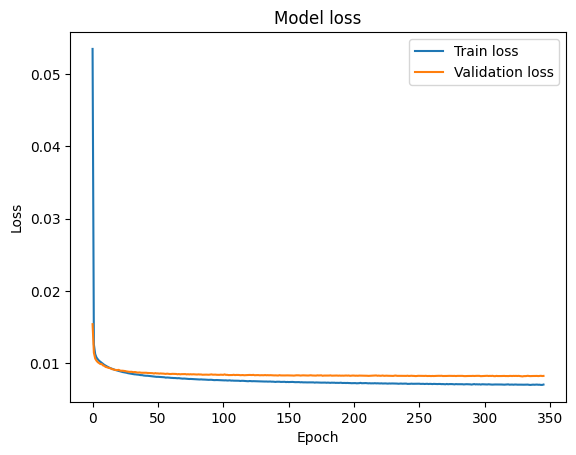

In [18]:
main_model.plot_loss(main_train_hist)

In [19]:
import gc
del X_train, y_train, X_valid, y_valid
gc.collect()

5253

Main instrument input shape: (12798, 32, 128)
Drums input shape: (12798, 32, 128)
Output shape: (12798, 32, 128)
Epoch 1/1000
340/340 [==============================] - 12s 17ms/step - loss: 0.0576 - val_loss: 0.0162
Epoch 2/1000
340/340 [==============================] - 4s 11ms/step - loss: 0.0100 - val_loss: 0.0087
Epoch 3/1000
340/340 [==============================] - 4s 11ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 4/1000
340/340 [==============================] - 5s 15ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 5/1000
340/340 [==============================] - 4s 10ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 6/1000
340/340 [==============================] - 4s 10ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 7/1000
340/340 [==============================] - 4s 12ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 8/1000
340/340 [==============================] - 4s 11ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 9/1000
340/340 [==============================] - 4s 10m

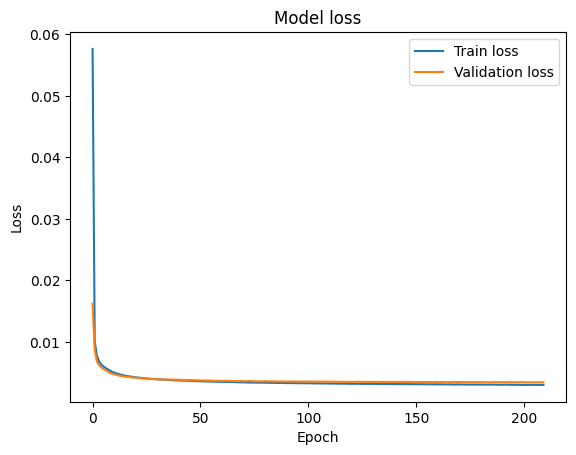

Main instrument input shape: (12798, 32, 128)
Guitar input shape: (12798, 32, 128)
Output shape: (12798, 32, 128)
Epoch 1/1000
340/340 [==============================] - 12s 14ms/step - loss: 0.0562 - val_loss: 0.0206
Epoch 2/1000
340/340 [==============================] - 4s 12ms/step - loss: 0.0170 - val_loss: 0.0161
Epoch 3/1000
340/340 [==============================] - 4s 12ms/step - loss: 0.0155 - val_loss: 0.0151
Epoch 4/1000
340/340 [==============================] - 4s 10ms/step - loss: 0.0149 - val_loss: 0.0145
Epoch 5/1000
340/340 [==============================] - 4s 10ms/step - loss: 0.0144 - val_loss: 0.0140
Epoch 6/1000
340/340 [==============================] - 4s 13ms/step - loss: 0.0140 - val_loss: 0.0137
Epoch 7/1000
340/340 [==============================] - 4s 11ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 8/1000
340/340 [==============================] - 4s 11ms/step - loss: 0.0133 - val_loss: 0.0130
Epoch 9/1000
340/340 [==============================] - 4s 13

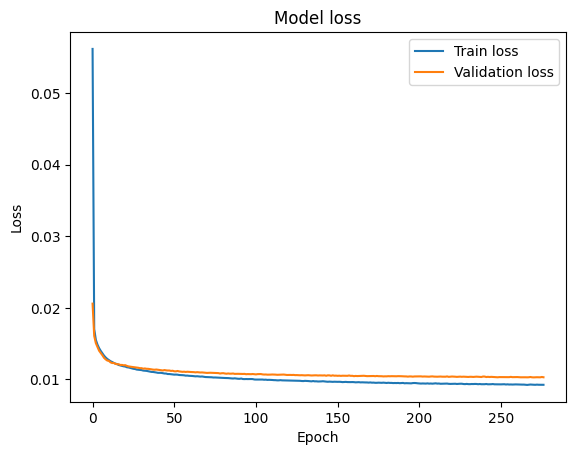

Main instrument input shape: (12798, 32, 128)
Bass input shape: (12798, 32, 128)
Output shape: (12798, 32, 128)
Epoch 1/1000
340/340 [==============================] - 13s 17ms/step - loss: 0.0511 - val_loss: 0.0108
Epoch 2/1000
340/340 [==============================] - 3s 10ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 3/1000
340/340 [==============================] - 5s 13ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 4/1000
340/340 [==============================] - 3s 10ms/step - loss: 0.0077 - val_loss: 0.0073
Epoch 5/1000
340/340 [==============================] - 3s 10ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 6/1000
340/340 [==============================] - 4s 11ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 7/1000
340/340 [==============================] - 4s 12ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 8/1000
340/340 [==============================] - 3s 10ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 9/1000
340/340 [==============================] - 3s 10ms

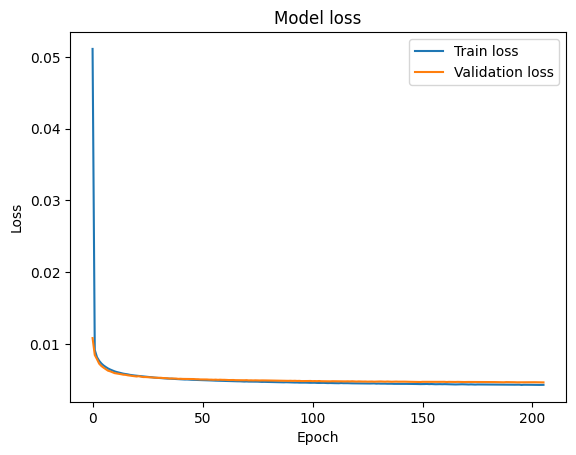

Main instrument input shape: (12798, 32, 128)
Strings input shape: (12798, 32, 128)
Output shape: (12798, 32, 128)
Epoch 1/1000
340/340 [==============================] - 13s 15ms/step - loss: 0.0615 - val_loss: 0.0244
Epoch 2/1000
340/340 [==============================] - 4s 10ms/step - loss: 0.0207 - val_loss: 0.0195
Epoch 3/1000
340/340 [==============================] - 5s 14ms/step - loss: 0.0190 - val_loss: 0.0185
Epoch 4/1000
340/340 [==============================] - 4s 11ms/step - loss: 0.0184 - val_loss: 0.0181
Epoch 5/1000
340/340 [==============================] - 3s 10ms/step - loss: 0.0181 - val_loss: 0.0177
Epoch 6/1000
340/340 [==============================] - 4s 12ms/step - loss: 0.0177 - val_loss: 0.0174
Epoch 7/1000
340/340 [==============================] - 4s 12ms/step - loss: 0.0174 - val_loss: 0.0171
Epoch 8/1000
340/340 [==============================] - 3s 10ms/step - loss: 0.0171 - val_loss: 0.0169
Epoch 9/1000
340/340 [==============================] - 3s 1

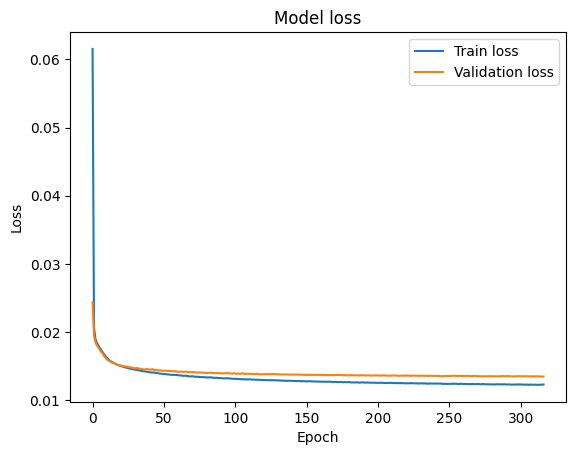

In [20]:
for instr in CONDITIONAL_INSTRUMENTS[DATASET]:

    model = models[instr]
    X_train_instr, X_valid_instr, y_train_instr, y_valid_instr = seq_generator.generate_sequences_conditional(instr)

    hist = model.fit_model(X_train_instr, y_train_instr, X_valid_instr, y_valid_instr, STORE_PATH)

    del X_train_instr, X_valid_instr, y_train_instr, y_valid_instr
    gc.collect()

    train_hists[instr] = hist
    model.plot_loss(hist)


### Proceso de generación

In [ ]:
sampler = MAESampleGenerator(models, encoder)

In [18]:
song_name=np.random.choice(list(encoder.encoded_files.keys()))
seed = {}
s=encoder.encoded_files[song_name]
start_ts = np.random.randint(s[MAIN_INSTRUMENT[DATASET]].shape[0]-SEQ_LEN)
for t,p in s.items():
    pianoroll = p
    s_in=pianoroll[start_ts:start_ts+SEQ_LEN,:]
    seed[t] = s_in
print(f'Song {song_name} from ts={start_ts} to ts={start_ts+32}')

Song G_V_B_cb50d24e03f113ba8655da7796116f55 from ts=738 to ts=770


In [19]:
# empty seed
e_seed = {}
for t,p in seed.items():
  e_seed[t] = np.zeros_like(p)

In [21]:
# validation seed for main instrument / zeros for everything else
seed_idx = np.random.randint(X_valid.shape[0])
valid_seed = X_valid[seed_idx]
valid_seed.shape
v_seed = {MAIN_INSTRUMENT[DATASET]: valid_seed}
for i in CONDITIONAL_INSTRUMENTS[DATASET]:
  v_seed[i] = np.zeros_like(valid_seed)


(32, 128)

In [ ]:
sampler.generate(seed,sample_length=3,threshold=0.1)
sampler.gen2midi()

TypeError: ignored

### Cargar modelos desde HDF5

In [ ]:
hdf5_dict = {'MELODY': 'weights/melody_autoencoder/POP909_MELODY_autoencoder.h5',
            'BRIDGE': 'weights/BRIDGE_cond_autoencoder/POP909_BRIDGE_cond_autoencoder.h5',
            'PIANO': 'weights/PIANO_cond_autoencoder/POP909_PIANO_cond_autoencoder.h5'}

In [ ]:
sampler = MAESampleGenerator(models, encoder)
sampler.load_from_hdf5(hdf5_dict)

Loaded from HDF5.


In [ ]:
thresh = {'MELODY': 0.2, 'BRIDGE': 0.15, 'PIANO': 0.3}
thresh_lpd = {'Piano': 0.1, 'Drums': 0.2, 'Guitar': 0.2, 'Bass': 0.3, 'Strings':0.15}

[[0.000e+00 3.931e+03]
 [1.000e+00 1.650e+02]]
Generated sample from ts=32 to ts=64.
[[0.000e+00 3.735e+03]
 [1.000e+00 3.610e+02]]
Generated sample from ts=64 to ts=96.
[[0.000e+00 3.628e+03]
 [1.000e+00 4.680e+02]]
Generated sample from ts=96 to ts=128.
[[0.000e+00 3.611e+03]
 [1.000e+00 4.850e+02]]
Generated sample from ts=128 to ts=160.
[[0.000e+00 3.606e+03]
 [1.000e+00 4.900e+02]]
Generated sample from ts=160 to ts=192.
Generated sample n.6
Saved with name lpd_5-conditionalAE_n_6.mid.


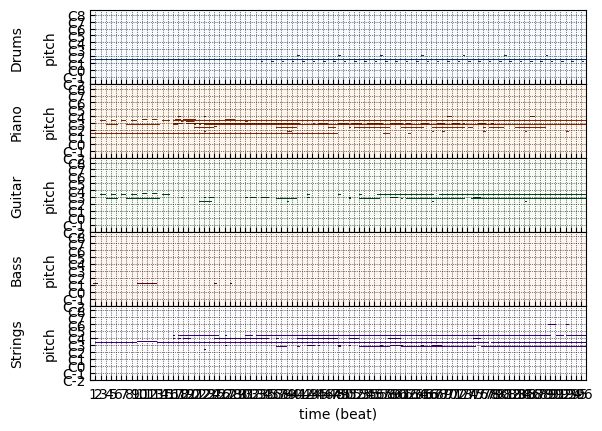

In [ ]:
sampler.generate(seed,thresh_lpd,sample_length=5)
sampler.gen2midi()

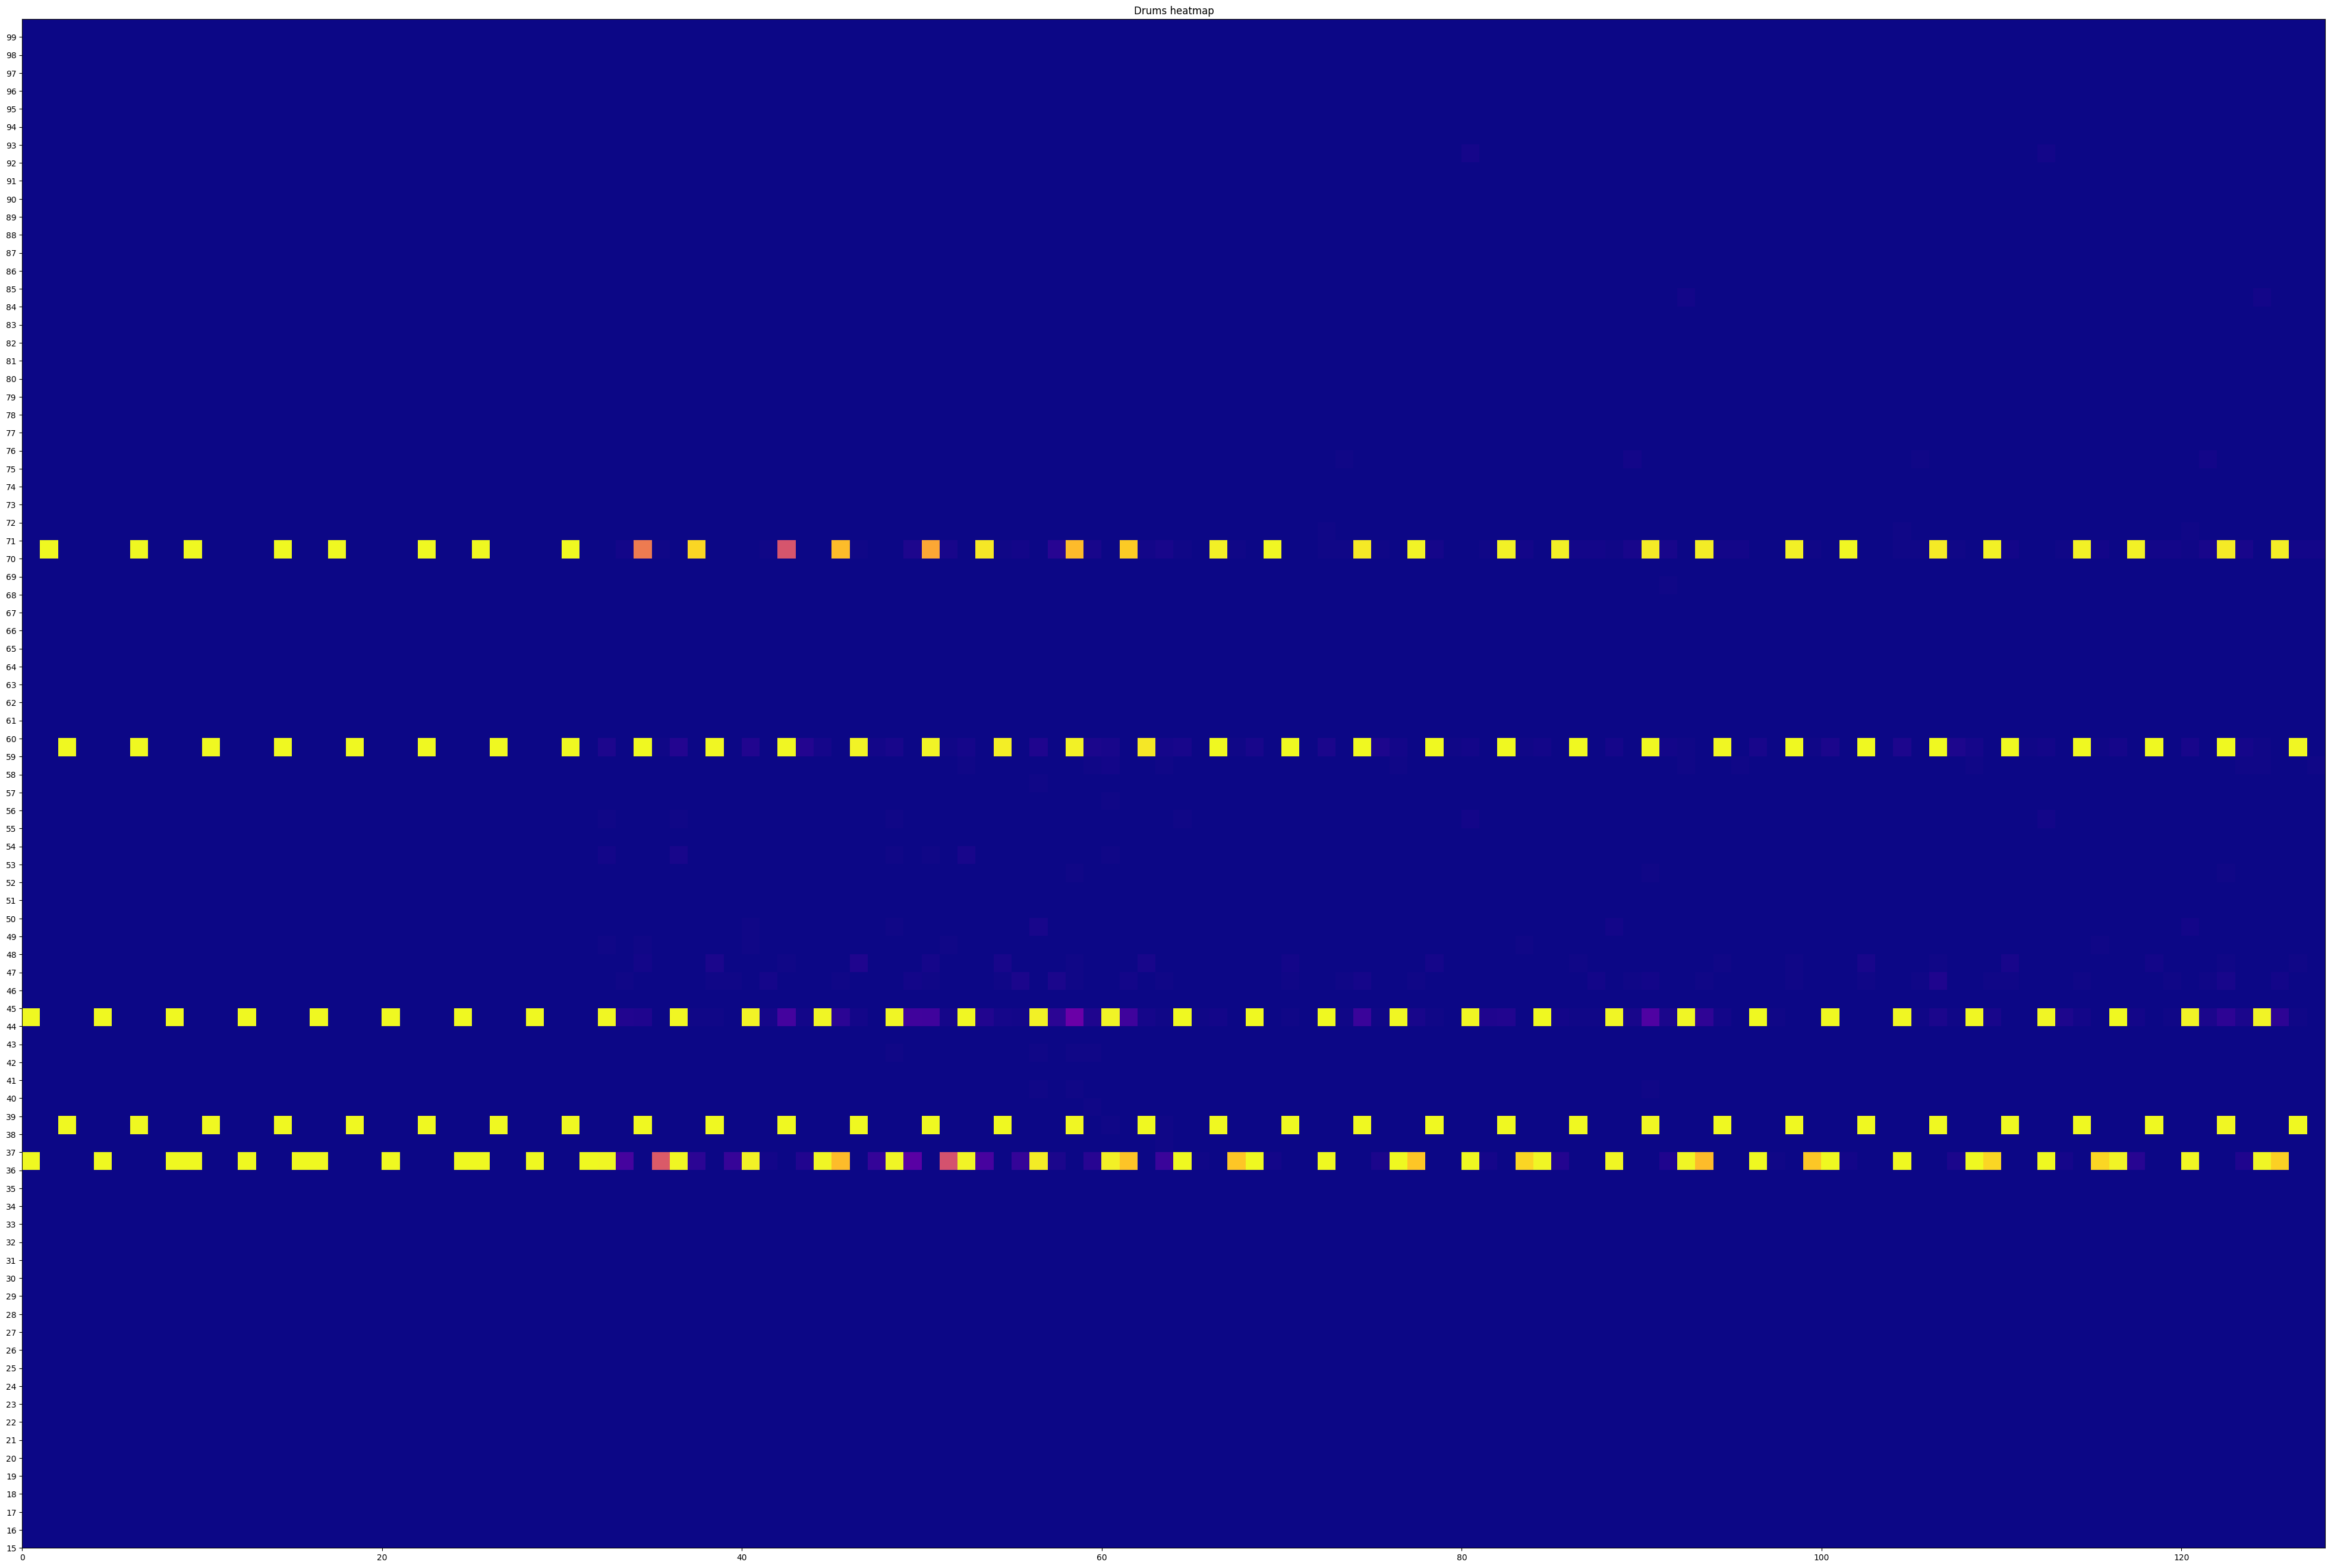

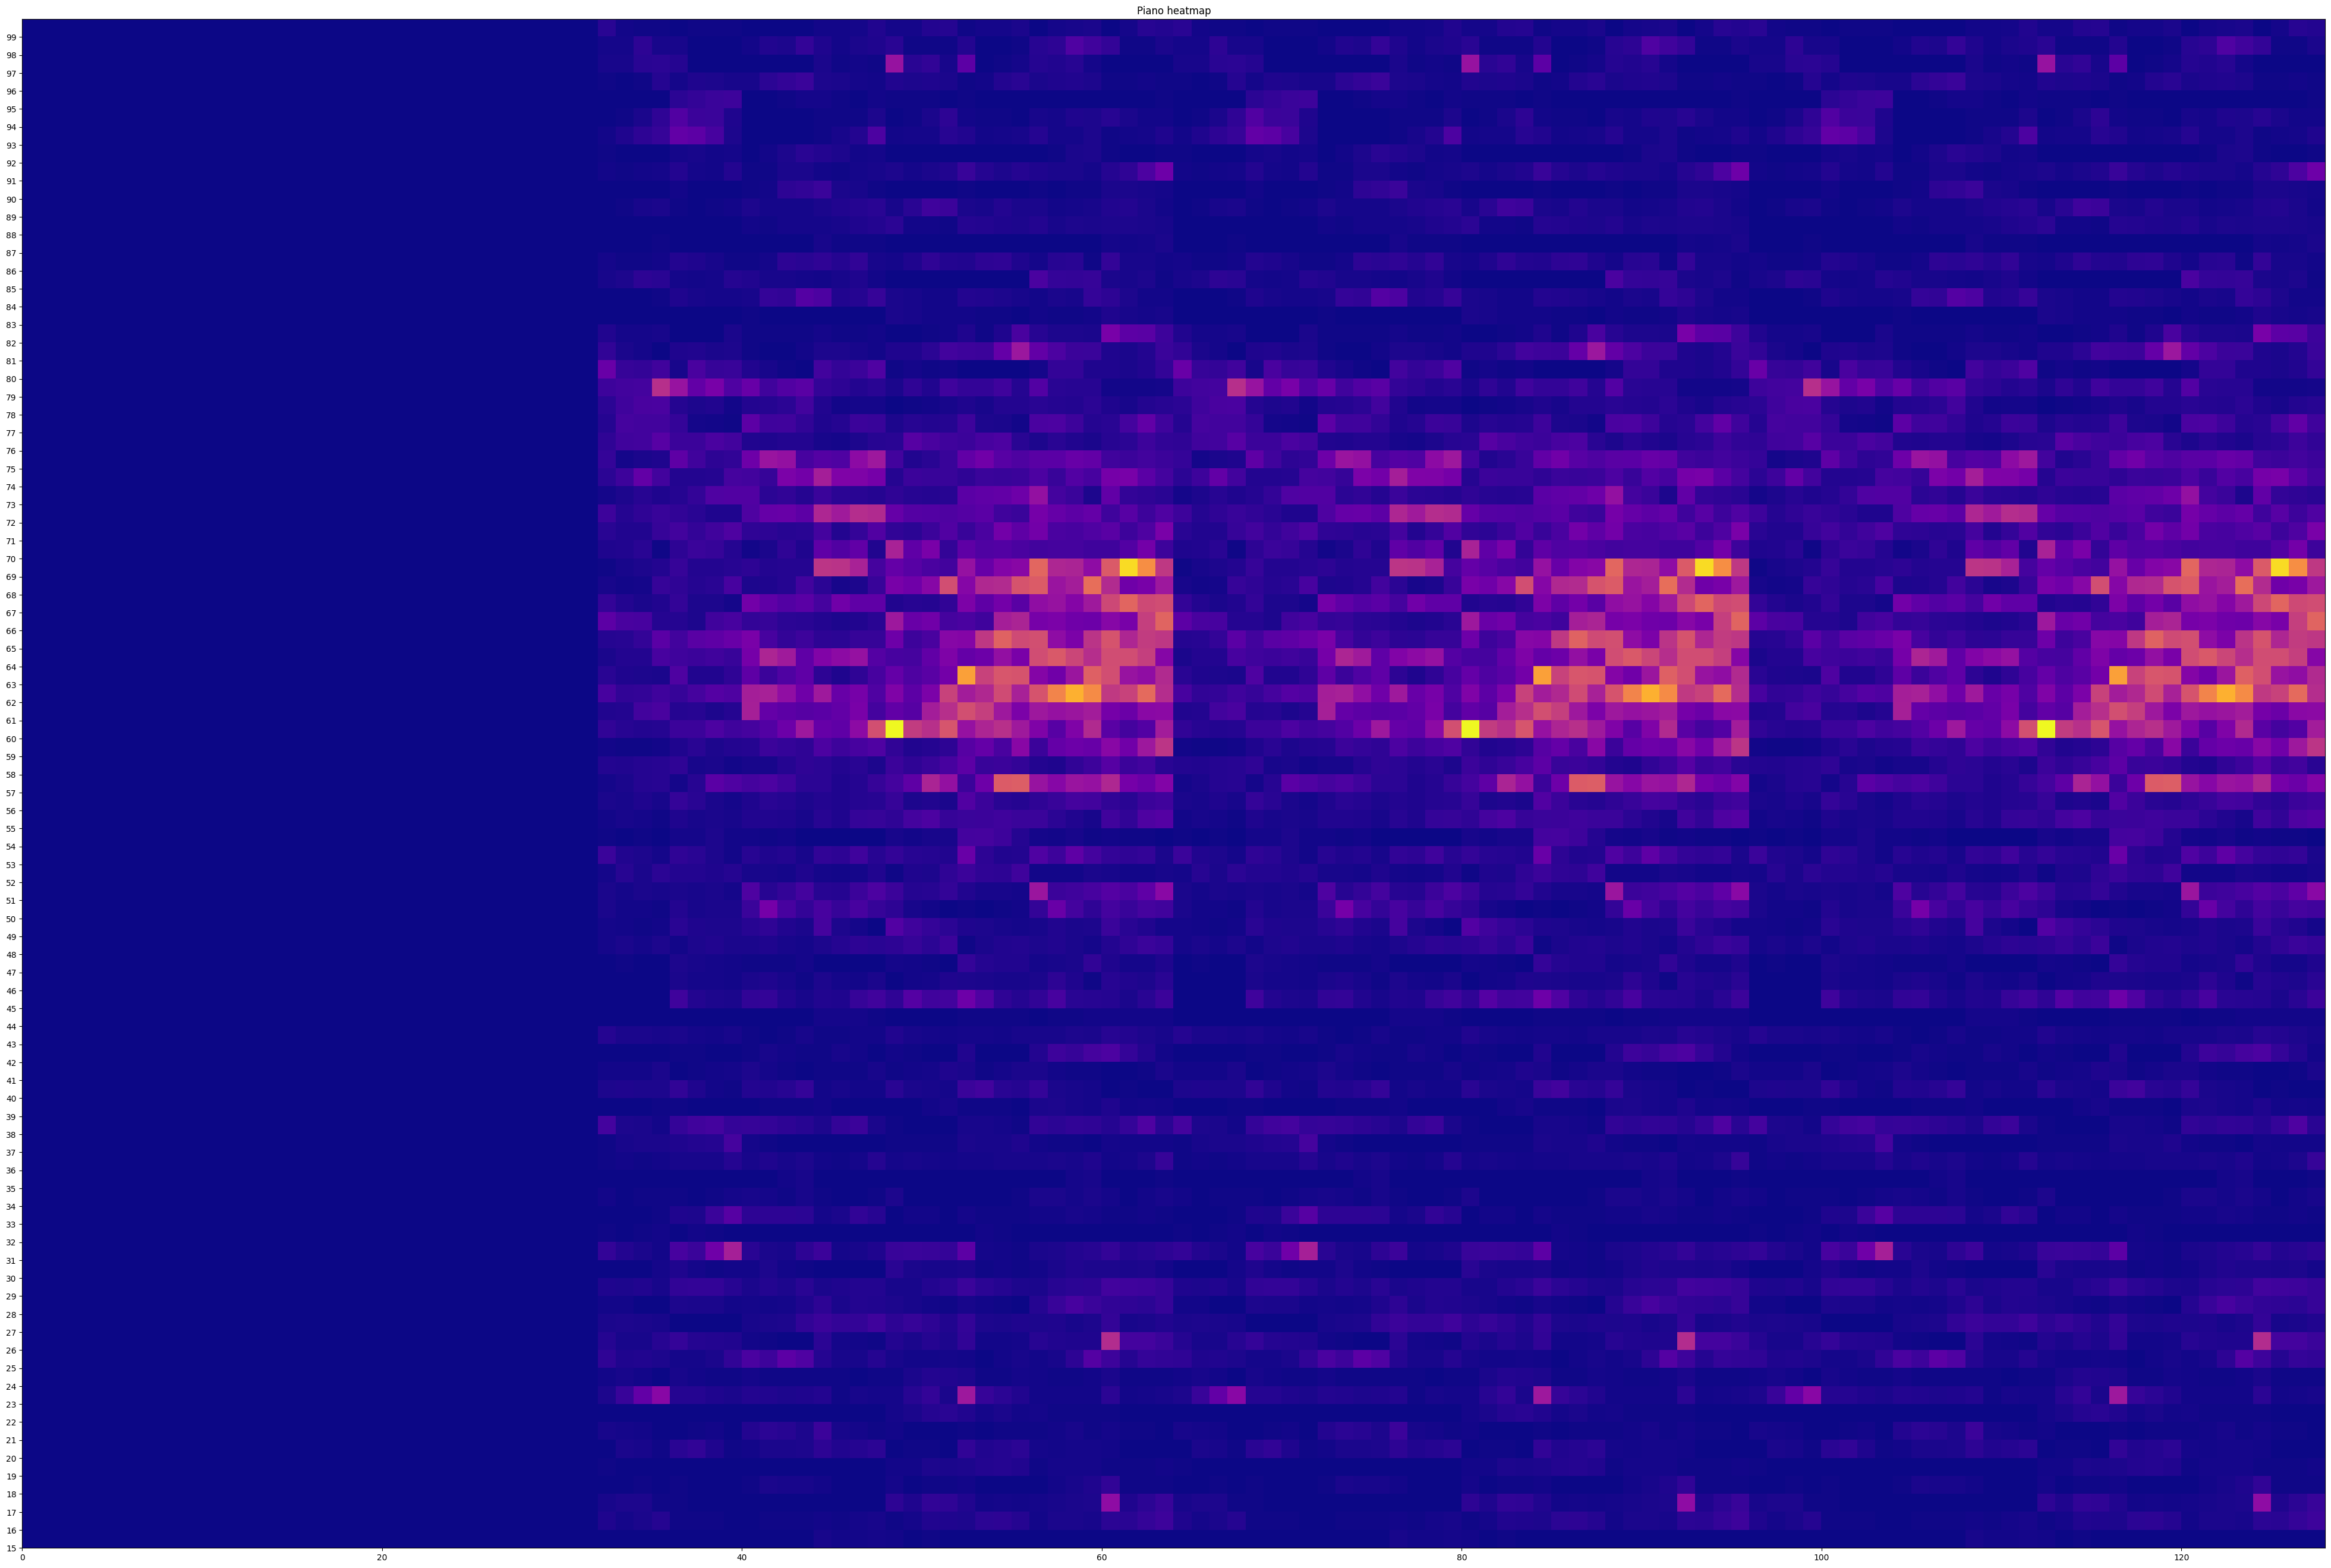

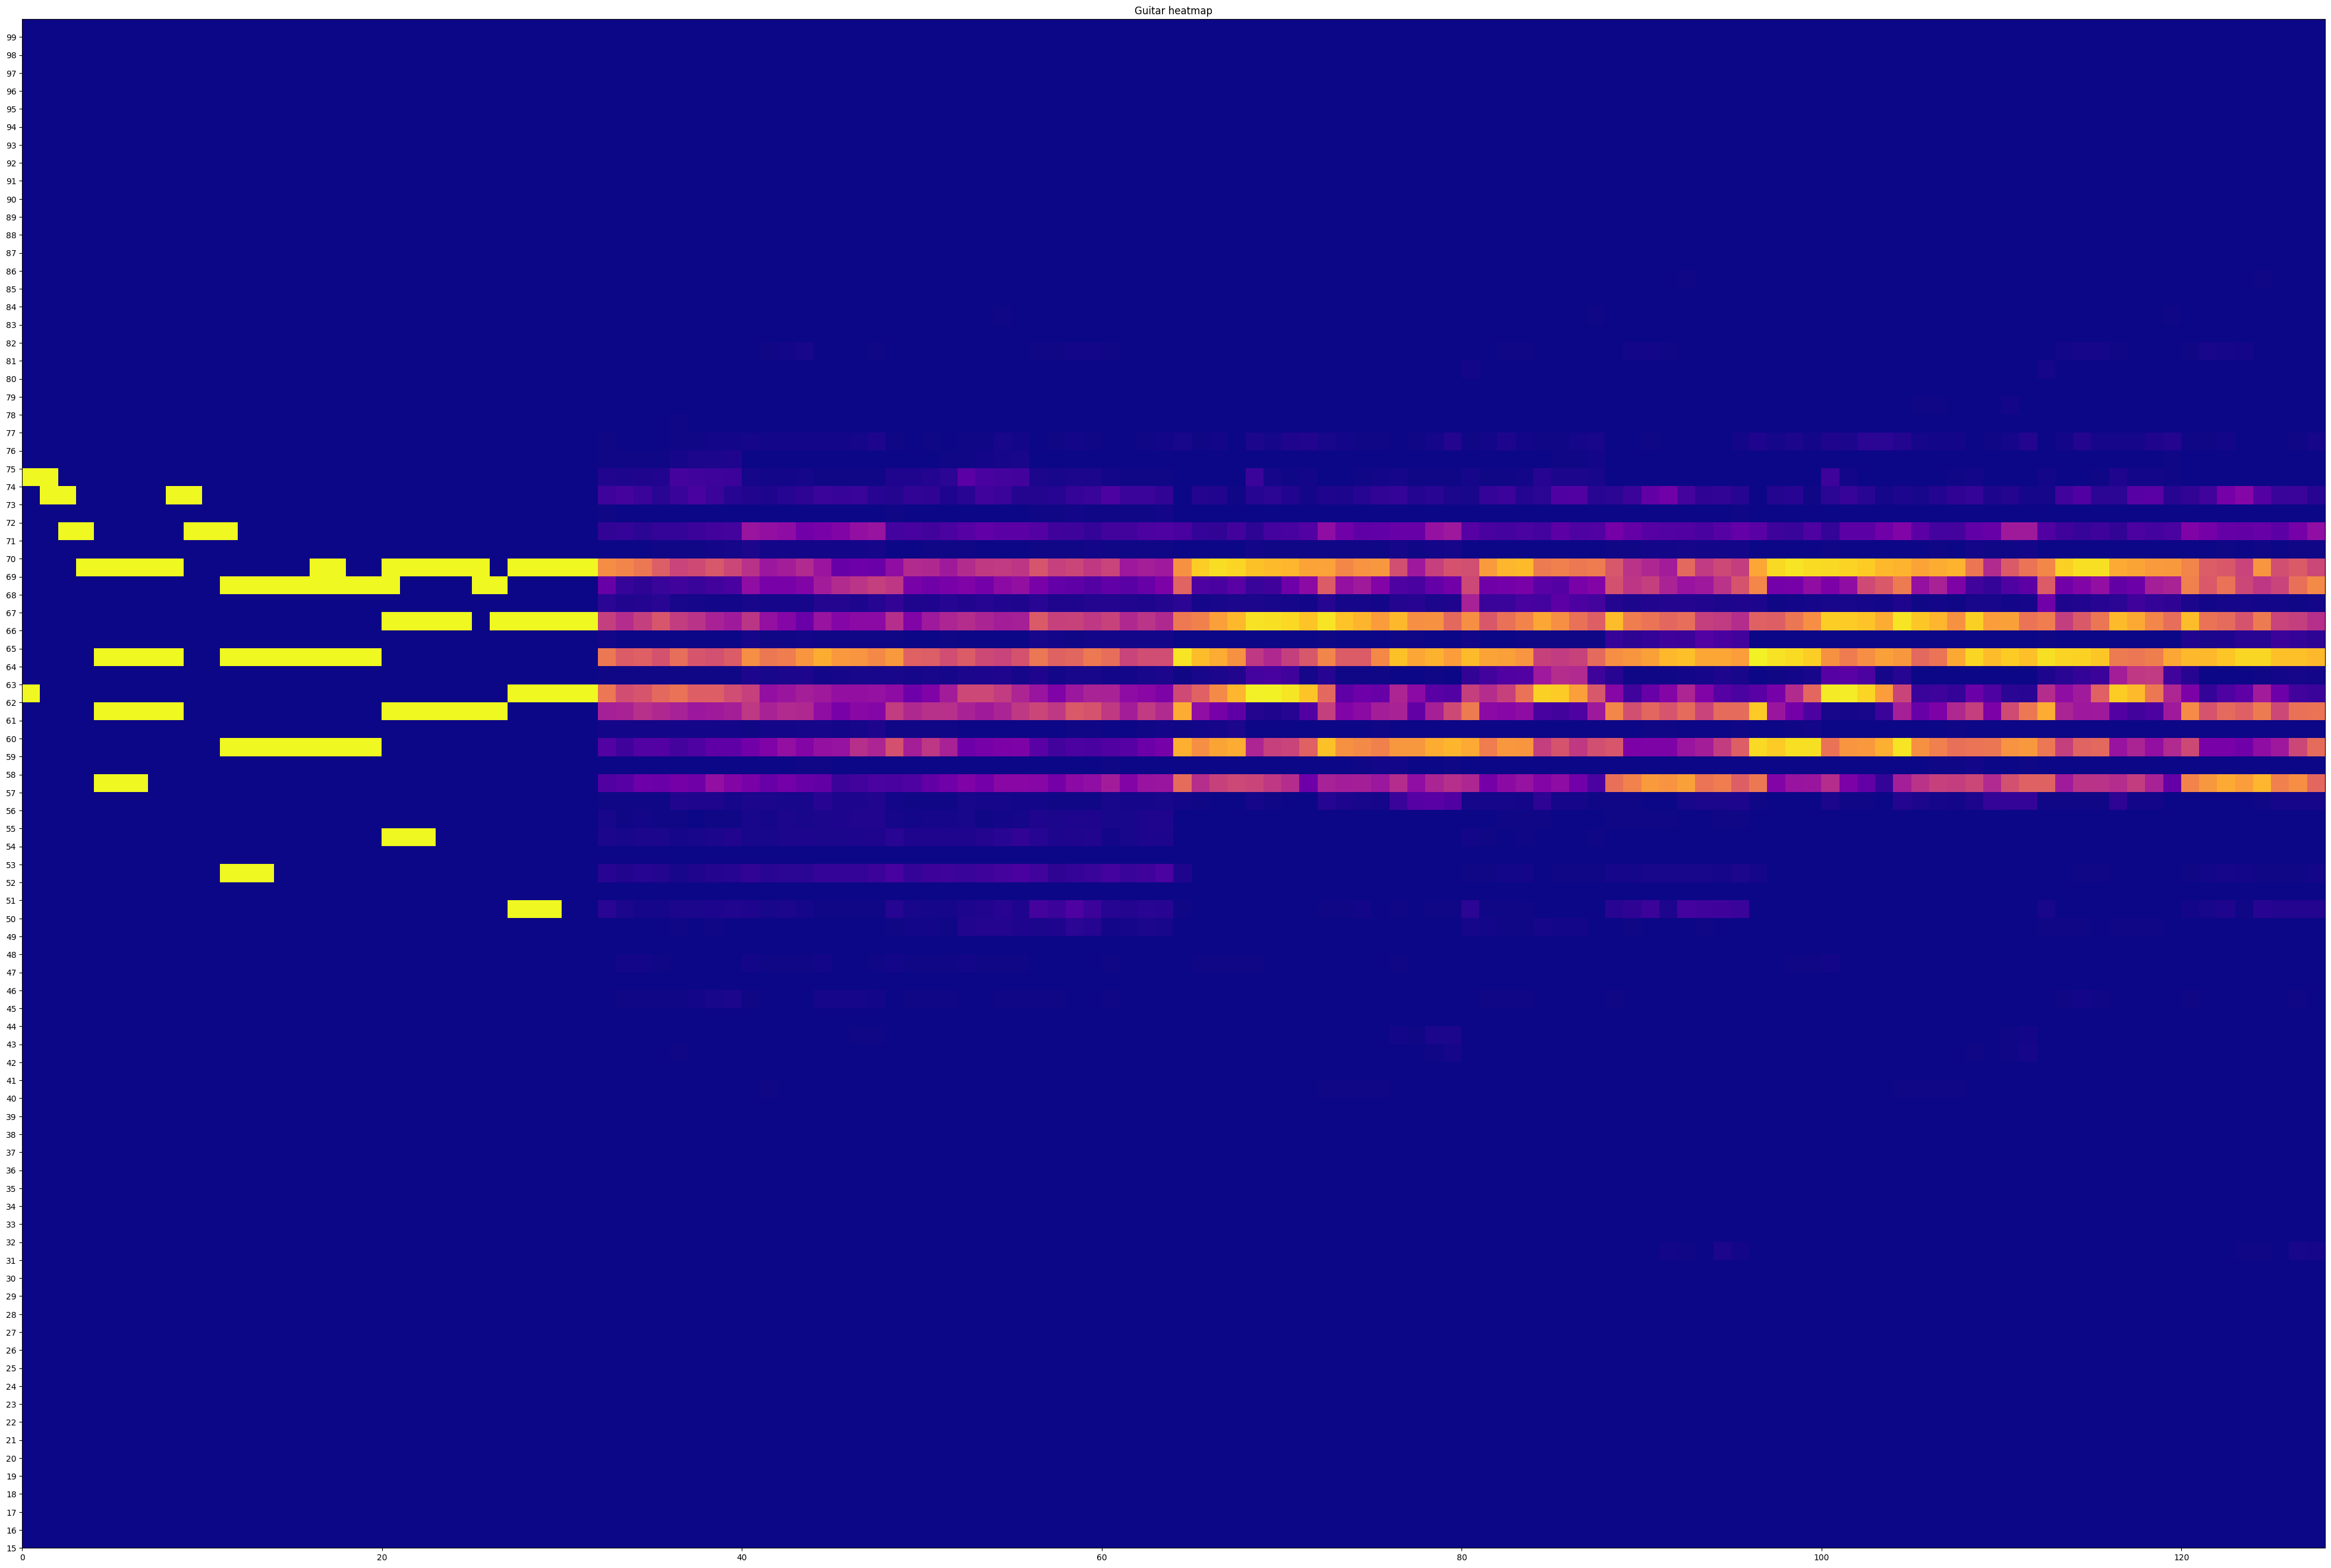

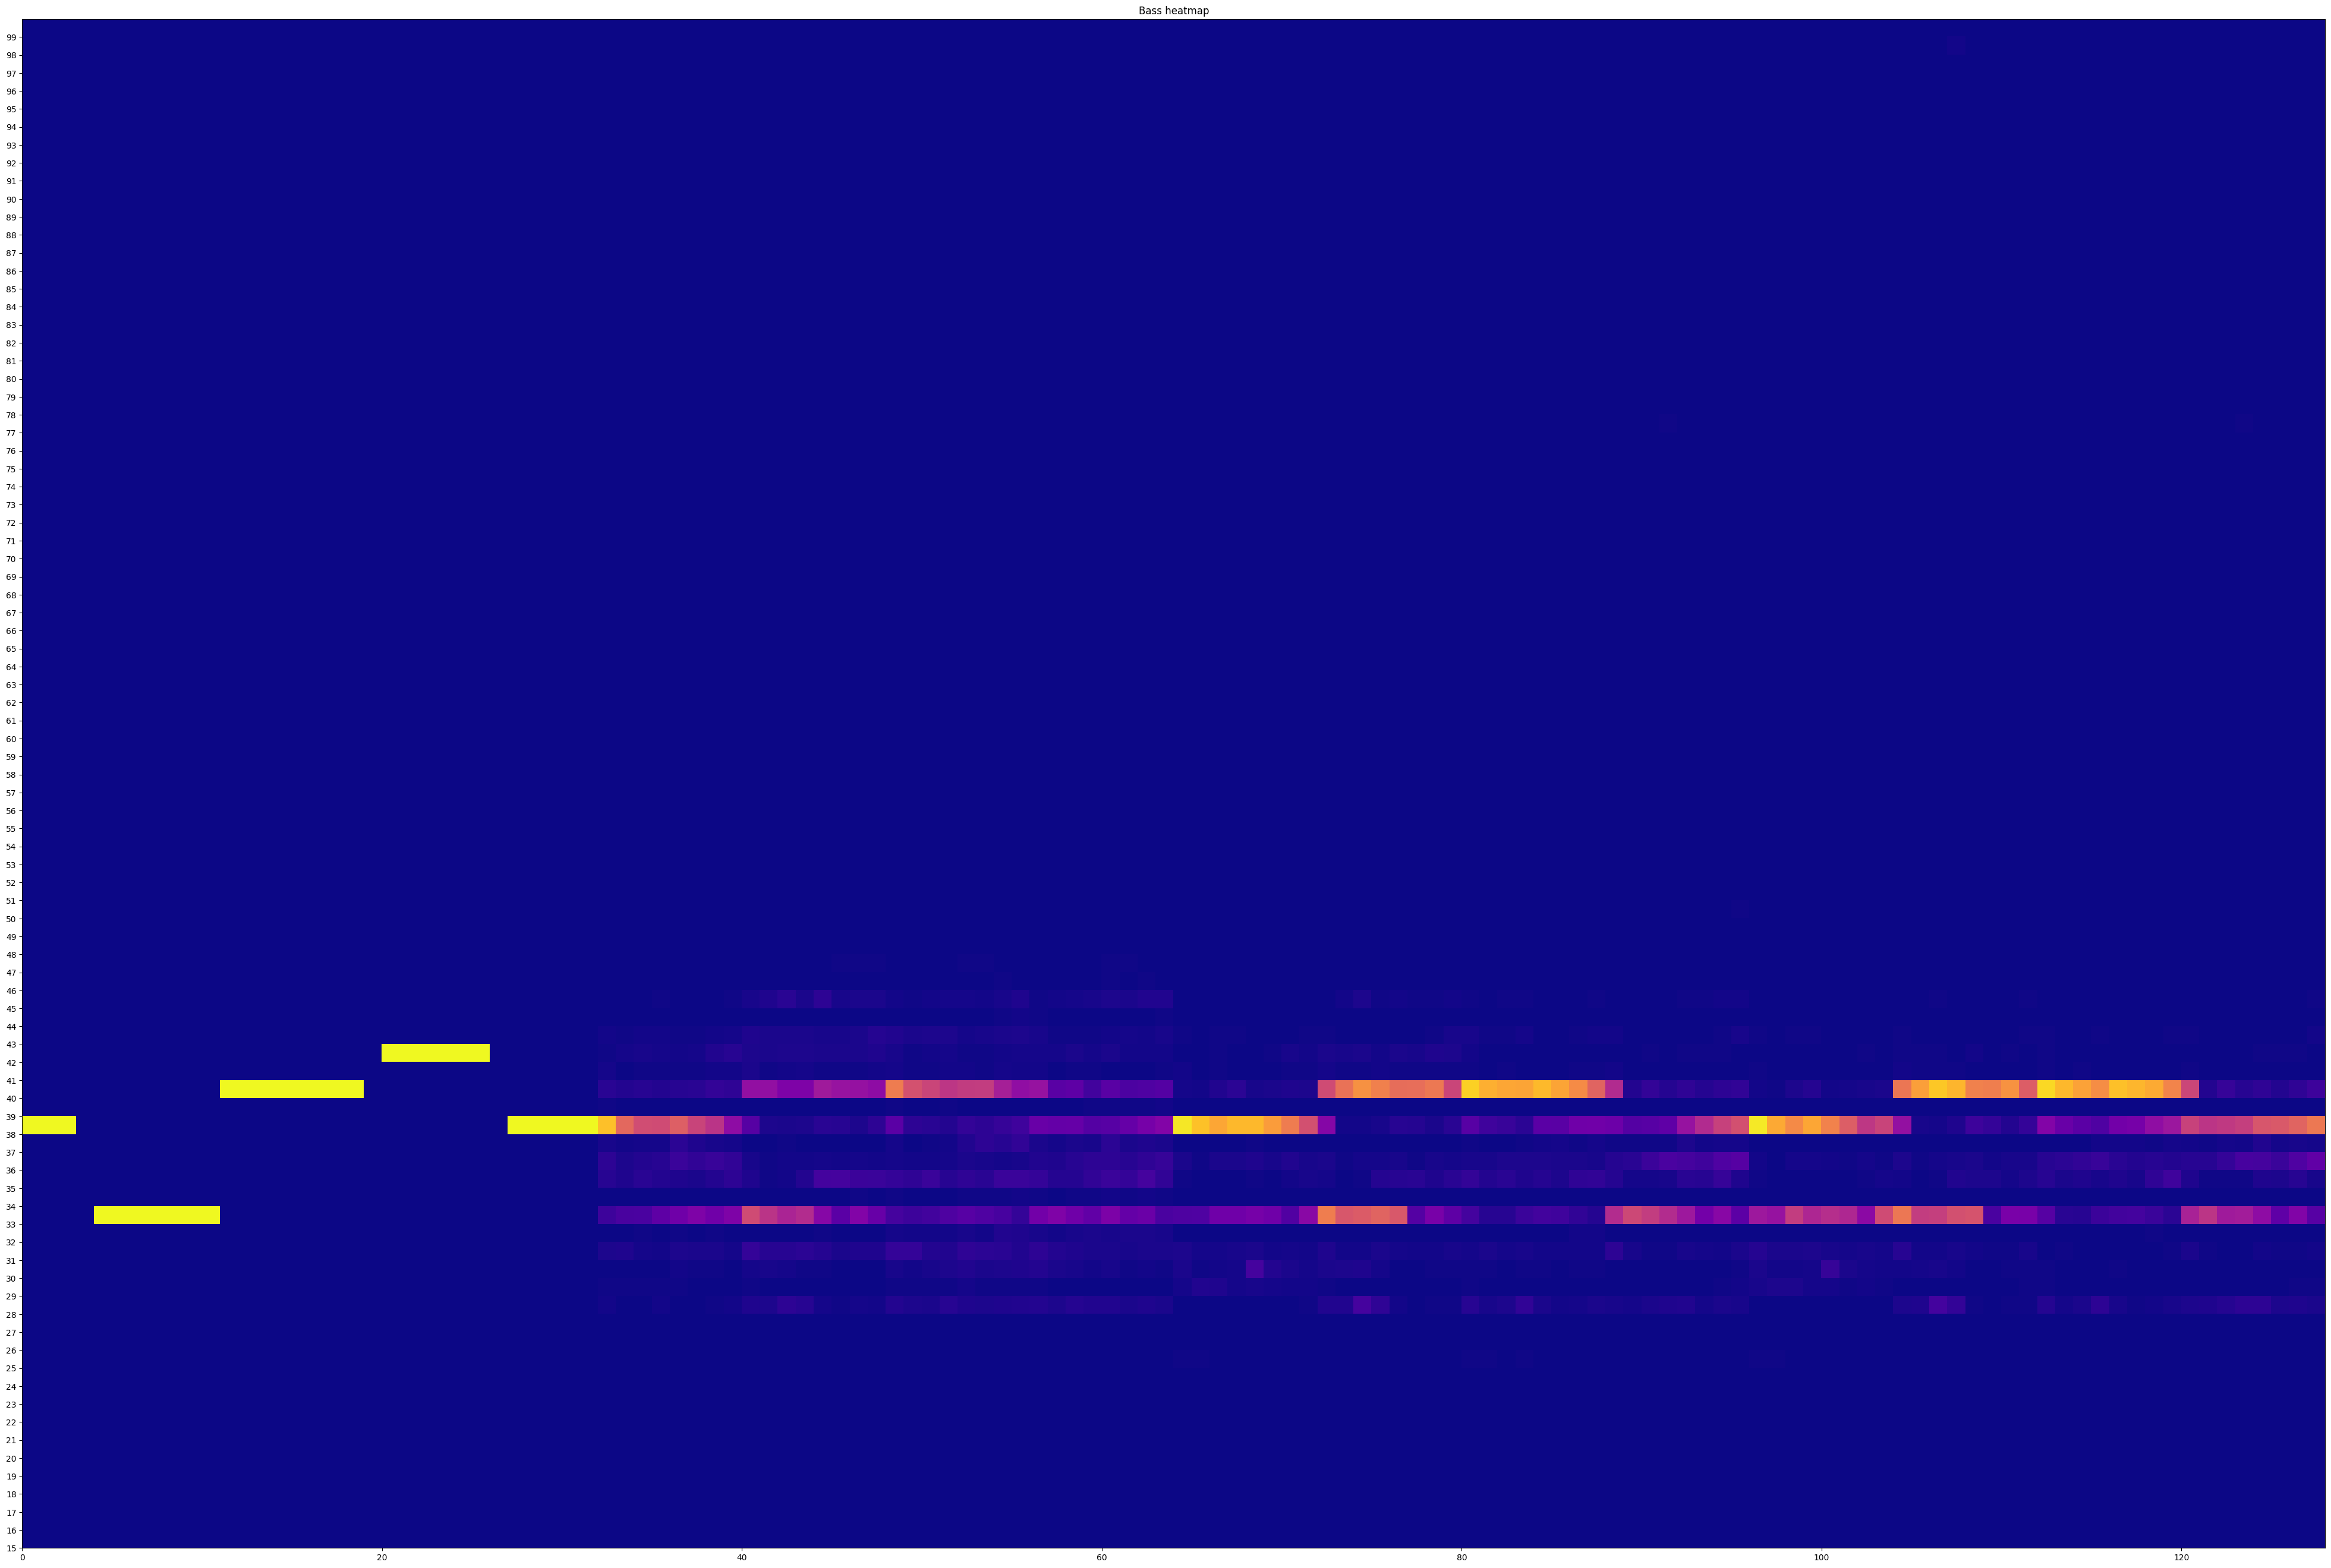

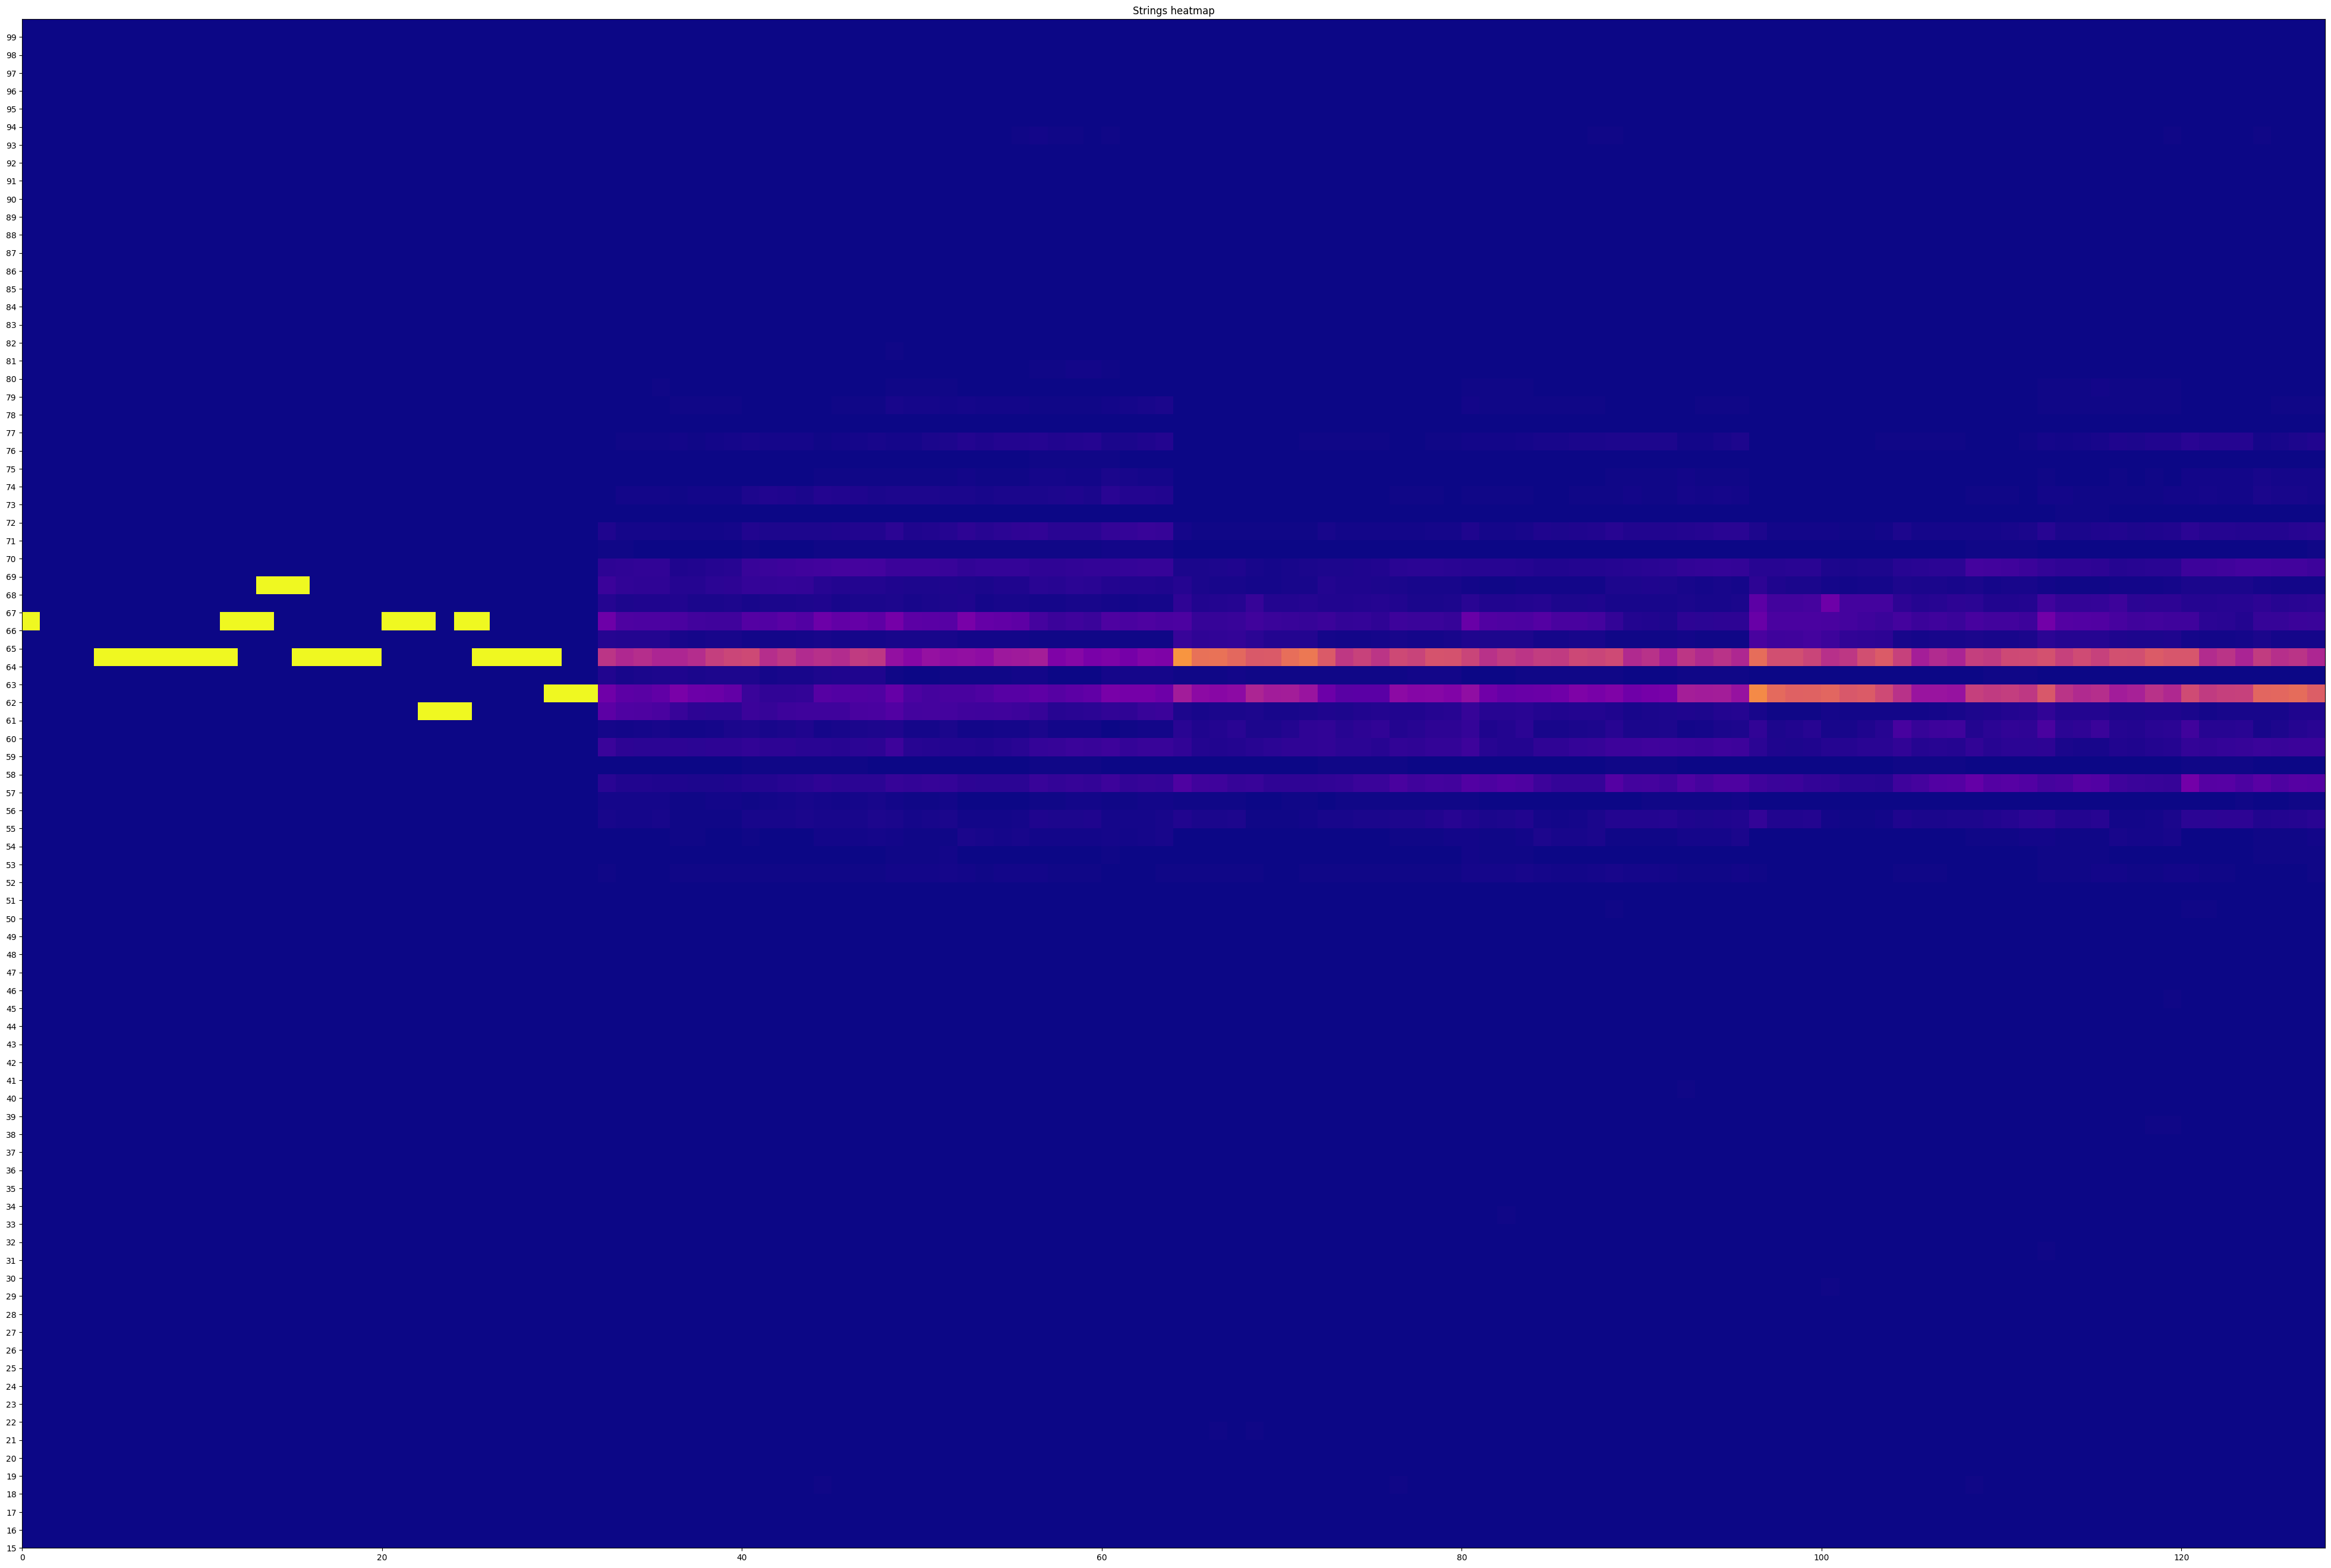

In [ ]:
sampler.plot_probs_heatmaps()